In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline


1.	Построить и отрисовать кривые обучения для любых 2х моделей - регрессорах.
Сделать вывод – какая из моделей более подходит для предложенного датасета,
Проанализировать наличие недо- или пере- обученности, выдвинуть предложение о значении целевого показателя выбранной метрики.
Отрисовать целевое значение на построенном графике кривых обучения.
Для одной из моделей отрисовать кривую обучения относительно ошибки.


In [87]:
data = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

feature_names = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS',
    'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'
]
X = pd.DataFrame(data, columns=feature_names)
y = pd.Series(target.flatten(), name='MEDV')

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_3812\691224291.py:2: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data, sep="\s+", skiprows=22, header=None)


In [88]:
X.shape

(506, 13)

In [89]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [93]:
y.head()

0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: MEDV, dtype: float64

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

In [130]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [132]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0)
}

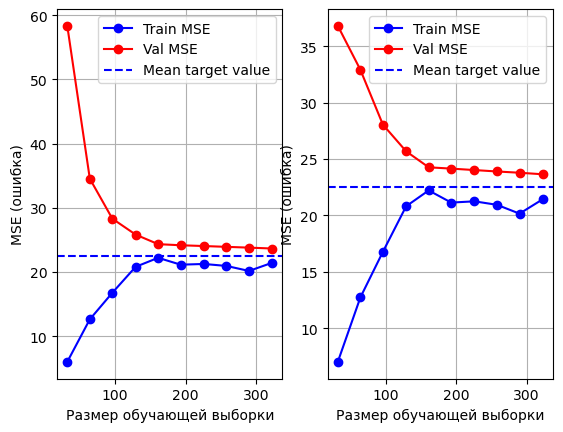

In [162]:
for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(1, 2, i)
    
    if "Ridge" in name:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test

    train_sizes, train_scores, val_scores = learning_curve(
        model, X_tr, y_train, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_mean_squared_error'
    )
    
    train_mean = -train_scores.mean(axis=1)
    val_mean = -val_scores.mean(axis=1)
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train MSE')
    plt.plot(train_sizes, val_mean, 'o-', color='red', label='Val MSE')
    plt.axhline(y=np.mean(y), color='b', linestyle='--', label='Mean target value')
    plt.xlabel('Размер обучающей выборки')
    plt.ylabel('MSE (ошибка)')
    plt.legend()
    plt.grid(True)

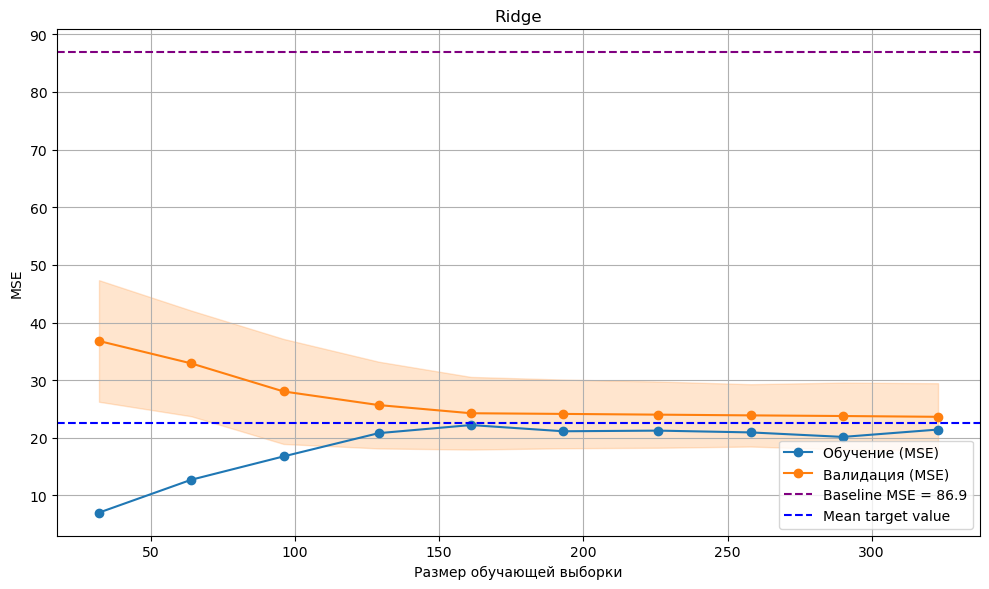

In [164]:
val_std = -val_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='tab:blue', label='Обучение (MSE)')
plt.plot(train_sizes, val_mean, 'o-', color='tab:orange', label='Валидация (MSE)')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='tab:orange', alpha=0.2)

baseline_mse = np.mean((y_train - np.mean(y_train)) ** 2)
plt.axhline(y=baseline_mse, color='purple', linestyle='--', label=f'Baseline MSE = {baseline_mse:.1f}')
plt.axhline(y=np.mean(y), color='b', linestyle='--', label='Mean target value')
plt.title('Ridge')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Вывод. Линейная регрессия и Ридж после обучения показывают стабильные результаты. Обе модели подходят для работы с датасетом. Так как кривые на обучении и на валидации с ростом данных сходятся, то можно сказать, что отсутствует переобучение. Из всех попробованных размеров тестовой выборки, лучше всего себя показывает коэффициент 0.2. При нем нет переобучения, как при 0.1, но присутствует небольшое недообучение. Целевой показатель метрики MSE примерно равен 22.5

2.	Последовательно выполнить обучение моделей линейной регрессии, гребневой регуляризации (Ridge)  и Lasso регуляризации. 
Сравнить модели используя несколько метрик.
Свести значения весовых коэффициентов в единую таблицу, сделать выводы о коллинеарности данных и о важности имеющихся признаков


In [224]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.1, max_iter=10000, random_state=42)
}


In [226]:
results = []
coefs = []

for name, model in models.items():
    if name == "Linear Regression":
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        coef = model.coef_
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        coef = model.coef_
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "MSE": mse,
        "MAE": mae,
        "R²": r2
    })
    coefs.append(coef)

In [228]:
metrics_df = pd.DataFrame(results)
print(metrics_df.to_string(index=False, float_format="%.4f"))

coef_df = pd.DataFrame(
    np.array(coefs).T,
    columns=["Linear", "Ridge", "Lasso"],
    index=feature_names
)
print("\nТаблица коэффициентов:")
print(coef_df.round(4))

            Model     MSE    MAE     R²
Linear Regression 24.2911 3.1891 0.6688
            Ridge 24.3129 3.1857 0.6685
            Lasso 25.6567 3.2418 0.6501

Таблица коэффициентов:
          Linear   Ridge   Lasso
CRIM     -0.1131 -0.9922 -0.7184
ZN        0.0301  0.6777  0.2596
INDUS     0.0404  0.2522 -0.0000
CHAS      2.7844  0.7225  0.6982
NOX     -17.2026 -1.9908 -1.5681
RM        4.4388  3.1516  3.2715
AGE      -0.0063 -0.1773 -0.0000
DIS      -1.4479 -3.0450 -2.2844
RAD       0.2624  2.1732  0.6719
TAX      -0.0106 -1.6956 -0.3567
PTRATIO  -0.9155 -2.0278 -1.8933
B         0.0124  1.1272  1.0314
LSTAT    -0.5086 -3.5990 -3.6094


Все три модели очень близки по все выбранным метрикам. Судя по r2 модели понимаю цену примерно у 65-67 процентов домов. При коэффициенте alpha = 0.1 у Lasso MSE больше, чем у других моделей, но если поставить этот коэф. равным 0.05, то MSE уже отличается на 0.4, а если равным 0.01, то отличие всего на 0.02. Но тогда меняются весовые коэф.

Коллинеарные признаки: NOX и INDUS, RAD и TAX, AGE и NOX. В линнейной регрессии присутствует экстримально большой коэф. NOX, однако после регуляризации в Ridge и Lasso экстримальность пропадает. Признаки INDUS и AGE являются слабыми и Lasso их практически зануляет. Важные признаки - LSTAT, RM и DIS, оказывают самое большое влияние на предсказание модели.

Попытаться реализовать ElasticNet модель. Сравнить с результатами полученными в п.2.

In [232]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000, random_state=42)
elastic.fit(X_train_scaled, y_train)
y_pred_elastic = elastic.predict(X_test_scaled)

mse_elastic = mean_squared_error(y_test, y_pred_elastic)
mae_elastic = mean_absolute_error(y_test, y_pred_elastic)
r2_elastic = r2_score(y_test, y_pred_elastic)

print("Результаты ElasticNet:")
print(f"MSE: {mse_elastic:.4f}")
print(f"MAE: {mae_elastic:.4f}")
print(f"R²:  {r2_elastic:.4f}")

coef_elastic = elastic.coef_
print("\nКоэффициенты ElasticNet:")
for name, coef in zip(feature_names, coef_elastic):
    print(f"{name:7}: {coef:8.4f}")

Результаты ElasticNet:
MSE: 25.2036
MAE: 3.1921
R²:  0.6563

Коэффициенты ElasticNet:
CRIM   :  -0.7612
ZN     :   0.3222
INDUS  :  -0.0310
CHAS   :   0.7369
NOX    :  -1.3960
RM     :   3.2336
AGE    :  -0.0961
DIS    :  -2.1759
RAD    :   0.8465
TAX    :  -0.6240
PTRATIO:  -1.8300
B      :   1.0403
LSTAT  :  -3.4038


ElsaticNet после обучение показывает результат между моделями Ridge и Lasso, но значительного улучшения результатов модель не показывает. Эту модель можно использовать для работы с данным датасетом, но никаких изменений по сравнению с другими моделями 